#  Прогнозирование заказов такси

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.signal import welch

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import (train_test_split, TimeSeriesSplit,
                                     RandomizedSearchCV)
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

# Импортирую библиотеку для отображения статус-бара
import tqdm

In [2]:
STATE = np.random.RandomState(12345)

## Подготовка

Сразу при открытии файла устанавливать индекс не буду- посмотрю пропуски

In [3]:
try:
    data = pd.read_csv('path_to/taxi.csv')
    print('Прочитали данные с диска')
except:
    data = pd.read_csv('/datasets/taxi.csv')
    print('Прочитали данные в сети')

Прочитали данные в сети


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Датасет не содержит содержит пустые значения (пропуски).

Установим в качестве индекса данные из поля datetime

In [5]:
# Установка нового индекса
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.sort_values('datetime')

In [6]:
data = data.set_index('datetime')

In [7]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Видим, что данныe являются десятиминутными срезами.

Прогнозировать буду значение суммы заказов за каждый час.

In [8]:
# преобразую данные в часовые интервалы и выполню агрегацию
hour = data.resample('1H').agg(['sum'])
hour.columns = hour.columns.droplevel(0)
hour

,sum
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Проверим равномерность приращений значений индекса

In [9]:
freq_uniform = (hour.index[1:] - hour.index[:-1]).value_counts()
if len(freq_uniform) == 1 and freq_uniform.index[0] == pd.Timedelta(hours=1):
    print("Индекс содержит равномерную частоту значений")
else:
    print("Индекс не содержит равномерную частоту значений")

Индекс содержит равномерную частоту значений


Значения индекса (времени) увеличиваются всегда на 1 час. Т.о. ряд полный, интерполяция не требуется

## Анализ

Разделю ряд на обучающую и тестовую выборки для исключения утечки при разложении на трендовую и сезонную составляющую

In [10]:
h, t = train_test_split(hour,shuffle=False,test_size=0.1)

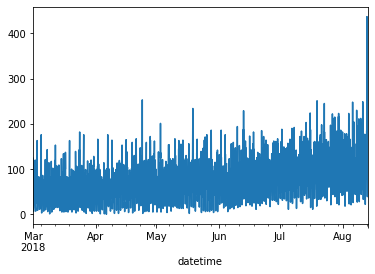

In [11]:
# посмотрим график для часовой сумммы за весь доступный период
h['sum'].plot();

Видим, что значения волатильны. Найдем наиболее значимые частоты. Использую функцию welch из библиотеки scipy для построения периодограммы. Параметр размера окна nperseg задам 1/4 длины ряда.

In [12]:
fs = 1 / pd.Timedelta("1 hour").total_seconds()  # частота дискретизации
f, Pxx = welch(h["sum"].values, fs=fs, nperseg=len(h) // 4)

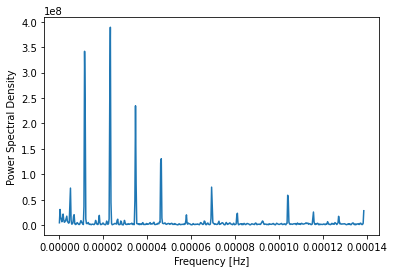

In [13]:
# построим диаграмму частота-плотность сигнала
plt.plot(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.show()

Видим 10 пиков плотности, которые соответствуют самым значимым частотам колебаний значений ряда. Выведем эти частоты

In [14]:
# Получение индексов 10 наибольших пиков
peak_indices = np.argsort(Pxx)[-10:]
for index in peak_indices:
    # Нахождение частоты и периода для текущего пика
    peak_frequency = f[index]
    peak_period = 1 / peak_frequency

    # Нахождение количества часов между колебаниями для текущего пика
    hours_between_cycles = peak_period /3600

    print(f"Частота: {peak_frequency:.8f} \
     Гц, Количество часов между колебаниями: {hours_between_cycles:.2f}")

Частота: 0.00000504      Гц, Количество часов между колебаниями: 55.17
Частота: 0.00006937      Гц, Количество часов между колебаниями: 4.00
Частота: 0.00003497      Гц, Количество часов между колебаниями: 7.94
Частота: 0.00004616      Гц, Количество часов между колебаниями: 6.02
Частота: 0.00004644      Гц, Количество часов между колебаниями: 5.98
Частота: 0.00001175      Гц, Количество часов между колебаниями: 23.64
Частота: 0.00003469      Гц, Количество часов между колебаниями: 8.01
Частота: 0.00002294      Гц, Количество часов между колебаниями: 12.11
Частота: 0.00001147      Гц, Количество часов между колебаниями: 24.22
Частота: 0.00002322      Гц, Количество часов между колебаниями: 11.96


Видим, что основные частоты это 55, 24, 8, 4, 12 часов.

Т.о. можно сказать, что значения повторяются с этими лагами.

Разложим данные на трендовую и сезонную составляющую

Посмотрим как изменяетя среднеквадратичное отклонение разности между трендом и исходным значением, в зависимости от размера усреднения (параметр period в seasonal_decompose)

In [15]:
# задаем список значений window_size
window_sizes = [2, 4, 6, 8, 12, 24, 48, 168]

# создаем пустой датафрейм для хранения результатов
result_df = pd.DataFrame(columns=['window_size', 'mean_res_seas', 'std_res_seas','mean_res','std_res'])

# цикл по window_size
for window_size in window_sizes:
    # рассчитываем decomposed для заданного window_size
    decomposed = seasonal_decompose(h['sum'], period=window_size)
    # извлекаем тренд из decomposed
    trend = decomposed.trend.dropna()
    season = decomposed.seasonal.dropna()
    # вычисляем разность между исходным рядом и трендом
    diff_res_seas = h['sum'] - trend
    diff_res = h['sum'] - trend - season
    # вычисляем статистические характеристики разности
    mean_res_seas = diff_res_seas.mean()
    std_res_seas = diff_res_seas.std()
    mean_res = diff_res.mean()
    std_res = diff_res.std()
    # сохраняем результаты в датафрейм
    result_df = result_df.append({'window_size': window_size,
                                  'mean_res_seas': mean_res_seas,
                                  'std_res_seas': std_res_seas,
                                  'mean_res': mean_res,
                                  'std_res': std_res},
                                 ignore_index=True)

In [16]:
result_df

,window_size,mean_res_seas,std_res_seas,mean_res,std_res
0,2.0,-0.004154,14.583349,-0.004154,14.386439
1,4.0,0.002928,21.329001,0.004826,20.510252
2,6.0,-0.002142,24.880001,-0.007465,23.309299
3,8.0,-0.022441,27.678994,-0.020144,24.554605
4,12.0,-0.017794,31.114982,-0.001809,26.075072
5,24.0,-0.010322,32.654828,-0.037029,21.802472
6,48.0,-0.056968,33.240623,-0.041287,22.585538
7,168.0,-0.038620,33.465425,-0.052870,20.663458


Видим, что среднеквадратичное отклонение для остатков, полученных при вычитании из исходных данных только трендовых значений, увеличивается при увеличении усреднения до 12 часов и далее почти не меняется. Для чистых остатков (вычитание тренда и сезонной составляющей) std растет при росте периода усреднения до 12 часов и далее снижается

Разложим ряд: в качестве периода усредения возьмем частоту равную 168, которая соответствует минимальной дисперсии чистых остатков.

In [17]:
de_168 = seasonal_decompose(h['sum'], period = 168)
de_168_trend = de_168.trend.dropna()
de_168_seas  = de_168.seasonal.dropna()
de_168_resid = de_168.resid.dropna()

Посмотрим график сезонной составляющей в произвольном окне размером 3 недели

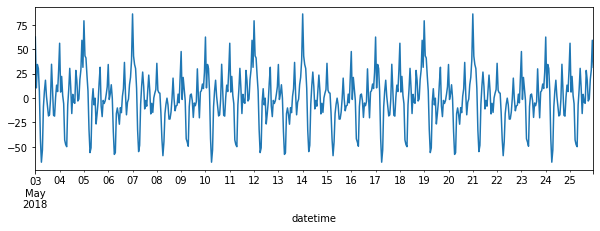

In [18]:
de_168_seas['2018-05-03':'2018-05-25'].plot(figsize=(10,3));

Частота повторения значений равна 168 часов. 

Оценим остатки разложения. Посмотрим их гистограмму.

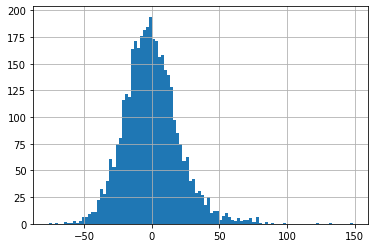

In [19]:
de_168_resid.hist(bins=100);

Визуально, можно говорить о нормальном распределении остатков (с хвостом выбросов справа). Оценим нормальность остатков.

In [20]:
from scipy.stats import normaltest

# Проверка нормальности распределения остатков
stat, p = normaltest(de_168_resid)
print(f"Statistic={stat}, p-value={p}")
if p < 0.1:
    print("Остатки не имеют нормальное распределение")
else:
    print("Остатки имеют нормальное распределение")

Statistic=480.4470941355685, p-value=4.701528631543165e-105
Остатки не имеют нормальное распределение


Формально остатки не распределены нормально. Т.е. теоретически - могут содержать важную информацию для прогнозирования.
Оценим, имеет ли смысл далее декомпозировать остатки

In [21]:
# посмотрим стандартное отклонение остатков
de_168_resid.std()

20.663457922987384

In [22]:
# посмотрим уменьшится ли стандартное отклонение для остатков,
# полученных при разложении текущих остатков также на тренд и сезон
print('Стандартное отклонение для тренда / остатков от остатков для периода  4:',
      round((seasonal_decompose(de_168_resid.dropna(), period = 4).trend.std()),3),' / ',
      round((seasonal_decompose(de_168_resid.dropna(), period = 4).resid.std()),3))
print('Стандартное отклонение для тренда / остатков от остатков для периода  8: ',
      round((seasonal_decompose(de_168_resid.dropna(), period = 8).trend.std()),3),' / ',
      round((seasonal_decompose(de_168_resid.dropna(), period = 8).resid.std()),3))
print('Стандартное отклонение для тренда / остатков от остатков для периода 12: ',
      round((seasonal_decompose(de_168_resid.dropna(), period = 8).trend.std()),3),' / ',
      round((seasonal_decompose(de_168_resid.dropna(), period = 8).resid.std()),3))

Стандартное отклонение для тренда / остатков от остатков для периода  4: 10.527  /  16.912
Стандартное отклонение для тренда / остатков от остатков для периода  8:  7.913  /  18.729
Стандартное отклонение для тренда / остатков от остатков для периода 12:  7.913  /  18.729


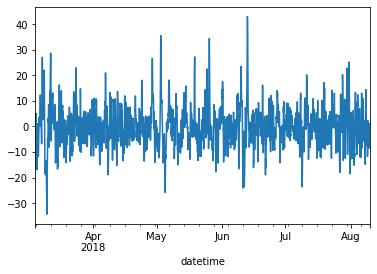

In [23]:
# также посмотрим на график для тренда от остатков на примере усреднения 8 часов
seasonal_decompose(de_168_resid.dropna(), period = 8).trend.plot();

Можно сделать вывод, что дальнейшая декомпозиция остатков значительно не уменьшает дисперсию следующих остатков, при том, что трендовая составляющая получает форму шума. Т.о. текущие остатки далее декомпозировать не имеет смысла

Теперь добавим полученную на трендовых данных сезонную составляющую и "растянем" ее на весь исходный датафрейм 

In [24]:
de_168_seas_first = de_168_seas[:168]
seas_repeated = np.tile(de_168_seas_first.values, hour.shape[0] // 168 + 1)[:hour.shape[0]]
hour['de_seas_168'] = seas_repeated

In [25]:
h = hour

 Посчитаем данные для скользащих средних (по сумме заказов за час) за 4, 8, 24 и 168 (неделя) часов.

In [26]:
h['sum_roll_4'] = h['sum'].rolling(4).mean()
h['sum_roll_8'] = h['sum'].rolling(8).mean()
h['sum_roll_24'] = h['sum'].rolling(24).mean()
h['sum_roll_168'] = h['sum'].rolling(168).mean()

Построим график для среднедневной и средненедельной скользящей средней

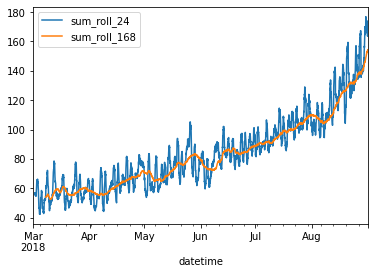

In [27]:
h[['sum_roll_24','sum_roll_168']].plot();

Отметим общий растущий тренд. На средненедельных данных можно увидеть некоторую амплитуду, но "на глаз" сделать вывод о сезонности для больших периодов нельзя

Посмотрим графики скользящих внутри недель. Предварительно, добавим поле "день недели" - dow

In [28]:
h['dow'] = h.index.dayofweek

In [29]:
# Функция для "красивой отрисовки" графика
def paint(h,date_begin,date_end,div,fields_list):
#     h           - датафрейм
#     date_begin  - дата-время начала окна данных
#     date_end    - дата-время конца окна
#     div         - делитель нацело для 24 для меток данных и сетки
#     fields_list - список полей значений для отрисовки
    # выбор периода и поля для отрисовки
    h_period = h[date_begin:date_end]
    # создание "двухэтажных" меток оси X
    xticklabels = [f"{h_period.index[i].strftime('%a')}\n---\n {hour}" 
                   if (i%12 == 0 and h_period.index[i].strftime('%H:%M') == '00:00') 
                   else (f"\n---\n{hour}" if i%div == 0 else "") 
                   for i, (dow, hour) in enumerate(zip(h_period['dow'], h_period.index.strftime('%H')))]
    # отрисовка графика
    fig, ax = plt.subplots(figsize=(10, 4))
    for field in fields_list:
        ax.plot(h_period.index, h_period[field], label=field)
        # ax.plot(h_period.index, h_period['sum_roll_12'], color='orange', label='sum_roll_12')
    ax.set_xticks(h_period.index)
    ax.set_xticklabels(xticklabels, fontsize=8)
    # нарисуем вертикальные линиии
    for i, (dow, hour) in enumerate(zip(h_period['dow'], h_period.index.strftime('%H'))):
        if i % div == 0:
            ax.axvline(h_period.index[i], linestyle=':', color='gray', alpha=0.5)
    ax.set_xlabel('Day of Week / Hour', labelpad=20)
    ax.xaxis.set_label_coords(0.5, -0.2)
    # ax.set_ylabel('sum_roll_6 / sum_roll_12 / sum')
    ax.legend()
    plt.show()

Посмотрим на поведение данных для разных временных промежутков. Окна данных будем брать равными 15-ми дням, чтобы охватить 2 недели и увидеть "на глаз" - как проявляется в данных внутринедельная частотность. Метки данных по оси X установлю кратными 12 часам

In [30]:
fields_list = ['sum','sum_roll_8','sum_roll_24']

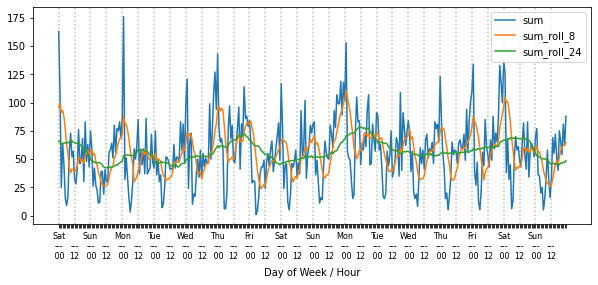

In [31]:
paint(h,'2018-03-03','2018-03-18',12,fields_list)

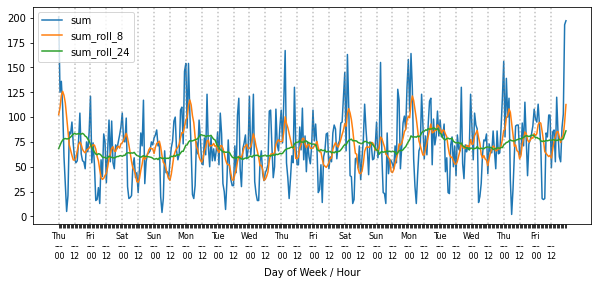

In [32]:
paint(h,'2018-05-03','2018-05-18',12,fields_list)

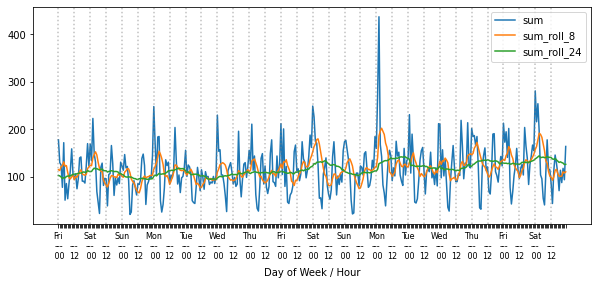

In [33]:
paint(h,'2018-08-03','2018-08-18',12,fields_list)

Видим, что для трех разных промежутков данные на графиках ведут себя похоже. При этом зависимости от дня недели (внутринедельной частотности) не обнаружено. Также видим, что на всех трех промежутках имеется внутридневная частотность.

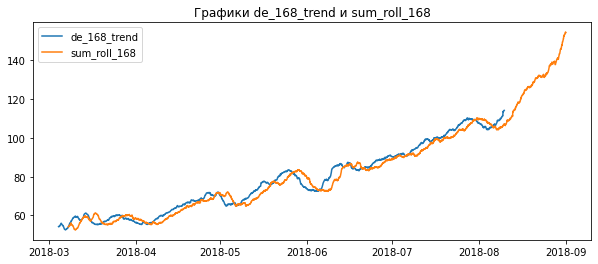

In [34]:
# посмотрим график трендовой составляющей
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(de_168_trend.index, de_168_trend, label='de_168_trend')
ax.plot(h['sum_roll_168'].index, h['sum_roll_168'], label='sum_roll_168')
ax.legend(loc='upper left')
ax.set_title('Графики de_168_trend и sum_roll_168')
plt.show()

График трендовой составляющей идентичен сдвинутому графику скользящей средней с периодом 168. Т.е. напрямую без сдвига признак de_trend_168 использовать в машинном обучении нельзя, т.к. это будет утечкой.

При этом сдвигать значения поля сезонной составляющей (на 168 шагов) не нужно, т.к. это будет "поворотом на 360 градусов", т.е. мы получим те же самые данные.

Посмотрим полученные данные

In [35]:
h.head(170)

,sum,de_seas_168,sum_roll_4,sum_roll_8,sum_roll_24,sum_roll_168,dow
datetime,,,,,,,
2018-03-01 00:00:00,124,62.541353,NaN,NaN,NaN,NaN,3
2018-03-01 01:00:00,85,10.430717,NaN,NaN,NaN,NaN,3
2018-03-01 02:00:00,71,34.456338,NaN,NaN,NaN,NaN,3
2018-03-01 03:00:00,66,30.394873,86.50,NaN,NaN,NaN,3
2018-03-01 04:00:00,43,6.806364,66.25,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...
2018-03-07 21:00:00,108,14.378310,83.25,65.125,56.166667,NaN,2
2018-03-07 22:00:00,127,9.792647,90.25,75.625,58.083333,NaN,2
2018-03-07 23:00:00,94,26.428129,101.25,81.000,60.041667,54.226190,2


In [36]:
h.tail(10)

,sum,de_seas_168,sum_roll_4,sum_roll_8,sum_roll_24,sum_roll_168,dow
datetime,,,,,,,
2018-08-31 14:00:00,133,-4.287363,150.50,153.000,172.875000,153.553571,4
2018-08-31 15:00:00,116,-5.354598,137.75,161.750,171.208333,153.547619,4
2018-08-31 16:00:00,197,28.352383,153.00,163.625,168.833333,153.601190,4
2018-08-31 17:00:00,217,17.930846,165.75,165.375,163.625000,153.880952,4
2018-08-31 18:00:00,207,-2.985415,184.25,167.375,164.875000,154.297619,4
2018-08-31 19:00:00,136,-0.949836,189.25,163.500,167.541667,154.434524,4
2018-08-31 20:00:00,154,18.947350,178.50,165.750,168.041667,154.285714,4
2018-08-31 21:00:00,159,28.930846,164.00,164.875,166.416667,154.244048,4
2018-08-31 22:00:00,223,59.233335,168.00,176.125,169.125000,154.130952,4


Сдвину скользящие средние и посчитаю разницу между лагом в 1 и 2 периода (для коротких скользящих), и разницу между лагами в 1 и 168 периодов для недельной скользящей. Посчитаю темп прироста скользящих.

In [37]:
h['sum_roll_4_1'] = h['sum_roll_4'].shift(1)
h['sum_roll_4_temp'] = (h['sum_roll_4_1'] - h['sum_roll_4'].shift(2))/h['sum_roll_4_1']
h['sum_roll_8_1'] = h['sum_roll_8'].shift(1)
h['sum_roll_8_temp'] = (h['sum_roll_8_1'] - h['sum_roll_8'].shift(2))/h['sum_roll_8_1']
h['sum_roll_24_1'] = h['sum_roll_24'].shift(1)
h['sum_roll_24_temp'] = (h['sum_roll_24_1'] - h['sum_roll_24'].shift(2))/h['sum_roll_24_1']
h['sum_roll_168_1'] = h['sum_roll_168'].shift(1)
h['sum_roll_168_temp'] = (h['sum_roll_168_1'] - h['sum_roll_168'].shift(168))/h['sum_roll_168_1']

Посмотрим полученные данные.

In [38]:
h.head(170)

,sum,de_seas_168,sum_roll_4,sum_roll_8,sum_roll_24,sum_roll_168,dow,sum_roll_4_1,sum_roll_4_temp,sum_roll_8_1,sum_roll_8_temp,sum_roll_24_1,sum_roll_24_temp,sum_roll_168_1,sum_roll_168_temp
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,62.541353,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,10.430717,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,34.456338,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,30.394873,86.50,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,6.806364,66.25,NaN,NaN,NaN,3,86.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-07 21:00:00,108,14.378310,83.25,65.125,56.166667,NaN,2,68.25,0.109890,58.500,0.089744,54.083333,-0.005393,NaN,NaN
2018-03-07 22:00:00,127,9.792647,90.25,75.625,58.083333,NaN,2,83.25,0.180180,65.125,0.101727,56.166667,0.037092,NaN,NaN
2018-03-07 23:00:00,94,26.428129,101.25,81.000,60.041667,54.226190,2,90.25,0.077562,75.625,0.138843,58.083333,0.032999,NaN,NaN


Заполню пропуски для полей сумм и скользящих средним значением за дату 2018-03-01 (можно и нулем, но почему бы и не средним значением - да, это будет такая мини-мини утечка в самом начале датасета, но, считаю, не влияющая на общий результат)

Пропуски в темпах прироста заполню нулем

In [39]:
h = h.dropna()

In [40]:
# вычисляем среднее значение для заполнения пропусков в полях без "_temp"
# fill_value = h.loc[:, ~h.columns.str.contains('_temp')].mean(axis=0)
# заполнение пропусков
# h = h.fillna(value={col: fill_value[col] if '_temp' not in col else 0 for col in h.columns})

In [41]:
h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4081 entries, 2018-03-14 23:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sum                4081 non-null   int64  
 1   de_seas_168        4081 non-null   float64
 2   sum_roll_4         4081 non-null   float64
 3   sum_roll_8         4081 non-null   float64
 4   sum_roll_24        4081 non-null   float64
 5   sum_roll_168       4081 non-null   float64
 6   dow                4081 non-null   int64  
 7   sum_roll_4_1       4081 non-null   float64
 8   sum_roll_4_temp    4081 non-null   float64
 9   sum_roll_8_1       4081 non-null   float64
 10  sum_roll_8_temp    4081 non-null   float64
 11  sum_roll_24_1      4081 non-null   float64
 12  sum_roll_24_temp   4081 non-null   float64
 13  sum_roll_168_1     4081 non-null   float64
 14  sum_roll_168_temp  4081 non-null   float64
dtypes: float64(13), int64(2)
mem

Целевым признаком будет поле 'sum', его сдвигать не надо.
Определим список полей признаков- из скользящих оставлю только 8 и 168 периодные

In [42]:
feat_list = ['dow'
             ,'de_seas_168'
#              ,'sum_roll_4_1','sum_roll_4_temp'
             ,'sum_roll_8_1','sum_roll_8_temp'
#              ,'sum_roll_24_1','sum_roll_24_temp'
             ,'sum_roll_168_1','sum_roll_168_temp'
            ]

In [43]:
h[feat_list+['sum']]

,dow,de_seas_168,sum_roll_8_1,sum_roll_8_temp,sum_roll_168_1,sum_roll_168_temp,sum
datetime,,,,,,,
2018-03-14 23:00:00,2,26.428129,64.875,0.017341,58.928571,0.079798,65
2018-03-15 00:00:00,3,62.541353,66.625,0.026266,58.755952,0.075170,123
2018-03-15 01:00:00,3,10.430717,74.625,0.107203,58.636905,0.074003,85
2018-03-15 02:00:00,3,34.456338,78.125,0.044800,58.678571,0.075269,55
2018-03-15 03:00:00,3,30.394873,76.875,-0.016260,58.619048,0.074127,42
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,4,-0.949836,167.375,0.011949,154.297619,0.143585,136
2018-08-31 20:00:00,4,18.947350,163.500,-0.023700,154.434524,0.142301,154
2018-08-31 21:00:00,4,28.930846,165.750,0.013575,154.285714,0.140625,159


## Обучение

Буду обучать 3 модели. Создам датафрейм для записи итоговых данных по моделям

In [44]:
models = ['Ridge','Random Forest','Light GBM']
model_results = pd.DataFrame(columns=['rmse_train','time_train','rmse_test','time_test'],
                             index=models,dtype=float)

In [45]:
train, test = train_test_split(h[feat_list+['sum']],shuffle=False,test_size=0.1)

In [46]:
features_train = train[feat_list]
target_train = train['sum']
features_test = test[feat_list]
target_test = test['sum']

Создам функцию для рандомного поиска гиперпараметров

In [47]:
def f_random_cv(model,grid,CV,score,features,target):
    random_cv = RandomizedSearchCV(estimator=model,
        param_distributions=grid,
        cv=CV, 
        scoring = score,
        n_jobs = -1,
        random_state=STATE)
    random_cv.fit(features, target)
    return random_cv

In [48]:
# для все моделей - метрика RMSE
scoring = 'neg_root_mean_squared_error'
# буду использовать кросс-валидацию, которая учитывает порядок временных рядов 
tscv = TimeSeriesSplit(n_splits=8)
CV = tscv

### Линейная ридж-регрессия

In [49]:
# Определяем модель Ridge
model_ridge = Ridge()
# Определяем диапазон параметра alpha
grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Подбираем лучшие гиперпараметры - расчет около 30сек
for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    random_cv_ridge = f_random_cv(model_ridge,grid,CV,scoring,features_train,target_train)

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


In [50]:
# лучшие гиперпараметры и значение метрики
print("Best params: ", random_cv_ridge.best_params_)
print("Best score: ", -1*random_cv_ridge.best_score_)

Best params:  {'alpha': 0.1}
Best score:  21.590958898062098


In [51]:
mean_fit_time = random_cv_ridge.cv_results_['mean_fit_time']
total_time = np.sum(mean_fit_time)

model_results.loc['Ridge',['rmse_train','time_train','rmse_test','time_test']]=\
[-1*random_cv_ridge.best_score_,total_time,'n/a','n/a']

### Случайный лес

In [52]:
# Определим списки значений гиперпараметров, которые будут использоваться в поиске
n_estimators_list = [int(x) for x in range(20, 200, 10)]
max_depth_list = [int(x) for x in range(1, 30, 3)]
# min_samples_split_list = [int(x) for x in range(2,40,4)]
# min_samples_leaf_list =  [int(x) for x in range(1,20,4)]

In [53]:
# Создадим сетку гиперпараметров
grid = {'n_estimators' : n_estimators_list,
       'max_depth': max_depth_list
#        ,'min_samples_split': min_samples_split_list
#        ,'min_samples_leaf' : min_samples_leaf_list
       }

In [54]:
# инициализируем модель. Все параметры - по умолчанию
model_rfr = RandomForestRegressor(random_state=STATE)

In [55]:
# 
for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    random_cv_rfr = f_random_cv(model_rfr,grid,CV,scoring,features_train,target_train)

100%|██████████| 1/1 [01:17<00:00, 77.84s/it]


In [56]:
# лучшие гиперпараметры и значение метрики
print("Best params: ", random_cv_rfr.best_params_)
print("Best score: ", -1*random_cv_rfr.best_score_)

Best params:  {'n_estimators': 160, 'max_depth': 22}
Best score:  23.069996106835404


In [57]:
mean_fit_time = random_cv_rfr.cv_results_['mean_fit_time']
total_time = np.sum(mean_fit_time)

model_results.loc['Random Forest',['rmse_train','time_train','rmse_test','time_test']]=\
[-1*random_cv_rfr.best_score_,total_time,'n/a','n/a']

### Light GBM

In [58]:
# инициализируем модель
model_lgb = lgb.LGBMRegressor()

In [59]:
# установим сетку гиперпараметров
grid = {
    'num_leaves': [
#         10, 20, 30, 40, 
        50]
    ,'learning_rate': [
#         0.01, 
        0.05
#         , 0.1, 0.5
    ]
    ,'max_depth': [-1
#                    , 5, 10, 20
                  ]
}

In [60]:
# Обучим модель на исходных данных - расчет около 30 сек
for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    random_cv_lgb = f_random_cv(model_lgb,grid,CV,scoring,features_train,target_train)

100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


In [61]:
# Выводим лучшие гиперпараметры и значение метрики
print("Best params: ", random_cv_lgb.best_params_)
print("Best score: ", -1*random_cv_lgb.best_score_)

Best params:  {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05}
Best score:  23.411667819134347


In [62]:
mean_fit_time = random_cv_lgb.cv_results_['mean_fit_time']
total_time = np.sum(mean_fit_time)

model_results.loc['Light GBM',['rmse_train','time_train','rmse_test','time_test']]=\
[-1*random_cv_lgb.best_score_,total_time,'n/a','n/a']
model_results

,rmse_train,time_train,rmse_test,time_test
Ridge,21.590959,0.024949,n/a,n/a
Random Forest,23.069996,9.276432,n/a,n/a
Light GBM,23.411668,1.140356,n/a,n/a


Лучше других выглядит ридж-регрессия.

## Тестирование

In [63]:
best_ridge = random_cv_ridge.best_estimator_
start = time.time()
pred_ridge = best_ridge.predict(features_test)
end = time.time()
best_ridge_pred_time = end-start
best_ridge_rmse = mean_squared_error(target_test, pred_ridge, squared=False)
model_results.loc['Ridge',['rmse_test','time_test']]=\
[round(best_ridge_rmse,3),round(best_ridge_pred_time,6)]
model_results.round(3)

,rmse_train,time_train,rmse_test,time_test
Ridge,21.591,0.025,40.902,0.001959
Random Forest,23.070,9.276,n/a,n/a
Light GBM,23.412,1.140,n/a,n/a


# Выводы

Для рабочей модели мне понадобились всего 4 признака. При этом, теоретически, качество можно еще улучшить, конструируя другие признаки:

- выявление пиков данных (разных по уровню)
- амплитуда между пиками
- темпы прироста между пиками

Посмотрим график предсказания и факта

In [186]:
def paint_test_pred(start_date,end_date):
    target_subset = target_test.loc[start_date:end_date]
    pred_subset = best_ridge.predict(features_test.loc[start_date:end_date])
    plt.plot(target_subset.index, target_subset, label='Реальные данные')
    plt.plot(target_subset.index, pred_subset, label='Предсказания')
    plt.xticks(rotation=90,fontsize=8)
    plt.legend()
    plt.show()

In [187]:
test_begin = test.index.min()
test_end   = test.index.max()
print('начало тестовой выборки:',test_begin,' / конец теста:',test_end)

начало тестовой выборки: 2018-08-14 23:00:00  / конец теста: 2018-08-31 23:00:00


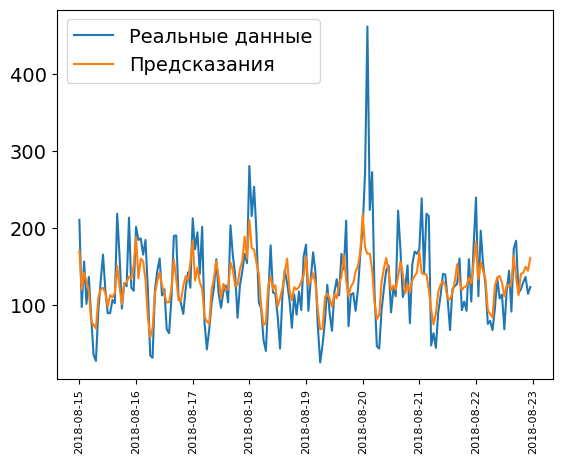

In [188]:
paint_test_pred('2018-08-15','2018-08-22')

Модель "правильно попадает в ритм, но не вытягивает ноты". Имеем более сглаженные данные. Соответственно, для пиковых часов, машин может не хватать.